In [1]:
from rec.core.modules.snis_distribution import SNISDistribution

import tensorflow as tf
tfl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

# Mixture of Gaussians

In [3]:
component_means = np.array([[-1, -1],
                            [-1, 0],
                            [-1, 1],
                            [0, -1],
                            [0, 0],
                            [0, 1],
                            [1, -1],
                            [1, 0],
                            [1, 1]], dtype=np.float32)
component_stds = 0.1

components = [tfd.Normal(loc=loc, scale=component_stds) for loc in component_means]

mixture = tfd.Mixture(cat=tfd.Categorical(probs=[[1 / 9] * 9] * 2),
                      components=components)

The log-likelihood of the importance sampler can be lower-bounded by

$$
\log p_{SNIS}(x) \geq \mathbb{E}_{x_{2:K}} \log \left[ \frac{\pi(x)w(x)}{\frac{1}{K}\left( \sum_{j=2}^K w(x_j) + w(x) \right)} \right ]
$$

The lower bound is equal to

$$
\mathbb{E}_{x_{2:K}}\left[ \log\pi(x) + \underbrace{U(x)}_{\log w(x)} + \log K - \log \left\{\sum_{j = 2}^K w(x_j) + w(x) \right\}\right]
$$

In [4]:
hidden = 20

# Create SNIS stuff
sn = tf.keras.Sequential([
        tfl.Dense(units=hidden,
                  activation=tf.nn.tanh),
        tfl.Dense(units=hidden,
                  activation=tf.nn.tanh),
        tfl.Dense(units=1)
])

sd = SNISDistribution(energy_fn=sn,
                      prior=tfd.Normal(loc=[0., 0.], scale=1.),
                      K=128)

In [5]:
save_dir = "/scratch/gf332/models/relative-entropy-coding/snis-experiments/synthetic/snis/"

ckpt = tf.train.Checkpoint(sd=sd)

manager = tf.train.CheckpointManager(ckpt, save_dir, max_to_keep=3)

# Initialize the model by passing zeros through it
sd.log_prob(tf.zeros([1, 2]))

# Restore previous session
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("No trained model found!")

Restored model from /scratch/gf332/models/relative-entropy-coding/snis-experiments/synthetic/snis/ckpt-195


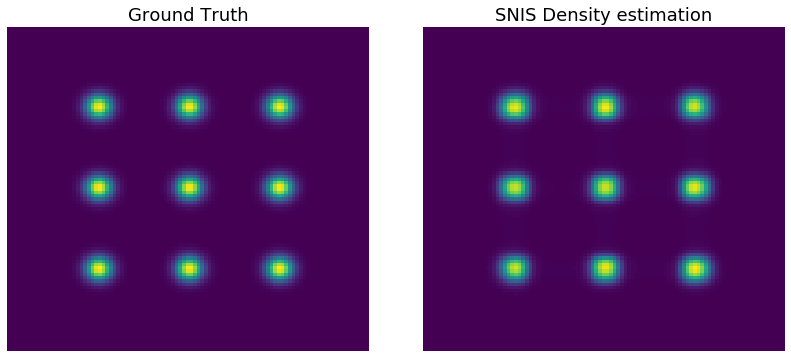

In [7]:
side = np.linspace(-2, 2, 100)
xs, ys = np.meshgrid(side, side)

points = np.vstack((xs.reshape([1, -1]), ys.reshape([1, -1])))
points = tf.transpose(tf.cast(points, tf.float32))

# Get ground truth plot
likelihoods = tf.reduce_prod(mixture.prob(points), axis=1).numpy()

# Get predicted plot
un_log_probs = tf.reduce_sum(sd.prior.log_prob(points), axis=1, keepdims=True) + sd.energy_fn(points)
log_Z = tf.reduce_logsumexp(un_log_probs)

log_probs = un_log_probs - log_Z

# Plot stuff
plt.figure(figsize=(12, 5))
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.15)

plt.subplot(121)
plt.title("Ground Truth", fontsize=18)
plt.pcolormesh(xs, ys, likelihoods.reshape(xs.shape))
plt.axis("off")

plt.subplot(122)
plt.title("SNIS Density estimation", fontsize=18)
plt.pcolormesh(xs, ys, tf.math.exp(log_probs).numpy().reshape(xs.shape))
plt.axis("off")

plt.show()

In [21]:
mixture.log_prob([-1, 1])

<tf.Tensor: id=1152, shape=(2,), dtype=float32, numpy=array([0.2850343, 0.2850343], dtype=float32)>

In [30]:
sd.log_prob_lower_bound([-1., 1.])

<tf.Tensor: id=1809, shape=(1, 1), dtype=float32, numpy=array([[0.1811924]], dtype=float32)>